In [73]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

## Model output

In [74]:
import cartopy.crs as ccrs
import fv3viz
import cftime
import vcm
from vcm.cubedsphere.grid_metadata import GridMetadataScream

In [75]:
plt.rcParams["figure.dpi"] = 120

In [76]:
run_paths = "../Corrective-ML/gpu-ml-0627-novelty.F2010-SCREAMv1.ne30pg2_ne30pg2.pm-gpu/tests/20x1_1x1_ndays_mlcorrected/run/output.scream.AVERAGE.nhours_x3.*.nc"
no_nov_path = "../Corrective-ML/gpu-ml-0617-1yr.F2010-SCREAMv1.ne30pg2_ne30pg2.pm-gpu/tests/20x1_1x1_ndays_mlcorrected/run/output.scream.AVERAGE.nhours_x3.*.nc"

In [77]:
verif = xr.open_zarr("../for_diags/verification/data_2d.zarr/")
baseline = xr.open_zarr("../for_diags/nudged_sim/data_2d.zarr/")

In [78]:
run = xr.open_mfdataset(run_paths)
no_novelty_run = xr.open_mfdataset(no_nov_path)

In [79]:
run["lat"] = verif.lat.isel(time=0).load()
run["lon"] = verif.lon.isel(time=0).load()

In [80]:
run["total_sfc_pr"] = run["precip_ice_surf_mass_flux"] + run["precip_liq_surf_mass_flux"]

In [81]:
def plot_single(ds, varname, ax=None, determine_cmap=True, robust=True, **kwargs):
    grid_metadata = GridMetadataScream("ncol", "lon", "lat")
    if ax is None:
        fig, ax = plt.subplots(
            figsize=(6, 3), dpi=120, subplot_kw={"projection": ccrs.Robinson()}
        )
    
    if determine_cmap:
        vmin, vmax, cmap = fv3viz.infer_cmap_params(ds[varname], robust=robust)
        kwargs = dict(vmin=vmin, vmax=vmax, cmap=cmap)
        
    fv3viz.plot_cube(
        ds,
        varname,
        grid_metadata=grid_metadata,
        ax=ax,
        **kwargs
    )
    
def plot_component_panels(ds, num_times, step_size=1):
    
    grid_metadata = GridMetadataScream("ncol", "lon", "lat")
    for i in range(num_times):
        fig, ax = plt.subplots(1, 2, figsize=(12,3), dpi=120, subplot_kw={"projection": ccrs.Robinson()})
        for j, varname in enumerate(["total_sfc_pr", "sfc_flux_sw_net"]):
            tidx = i*step_size
            dat = ds[varname].isel(time=tidx)
            title = f"{varname}"
            if j == 0:
                title = f"time={dat.time.values.item()}\n" + title
            fv3viz.plot_cube(
                ds.isel(time=tidx),
                varname,
                grid_metadata=grid_metadata,
                ax=ax[j],
            )
            ax[j].set_title(title)
#             plt.subplots_adjust(left=0.01, right=0.75, bottom=0.02)
        plt.show() 

In [11]:
run_col_wv = run.VapWaterPath.sel(time=slice(cftime.DatetimeNoLeap(2010, 1, 21))).mean(dim="ncol").load()
verif_col_wv = verif.water_vapor_path.sel(time=slice(run_col_wv.time[-1])).mean(dim="ncol").load()

In [12]:
baseline_wv = baseline.water_vapor_path.sel(time=slice(run_col_wv.time[-1])).mean(dim="ncol").load()

In [16]:
no_nov_wv = no_novelty_run.VapWaterPath.sel(time=slice(cftime.DatetimeNoLeap(2010, 1, 21))).mean(dim="ncol").load()

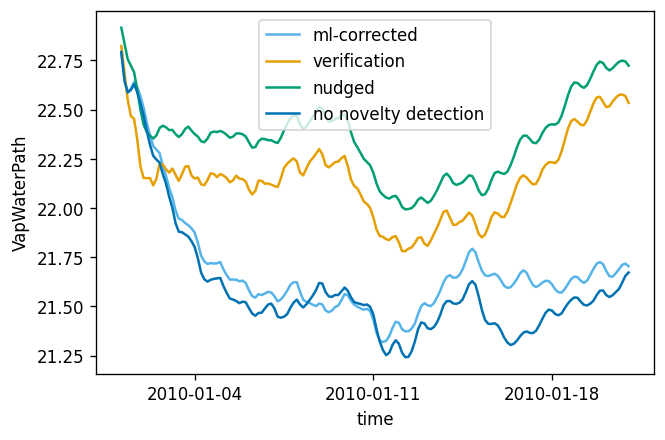

In [17]:
plt.figure(dpi=120)
run_col_wv.plot(label="ml-corrected")
verif_col_wv.plot(label="verification")
baseline_wv.plot(label="nudged")
no_nov_wv.plot(label="no novelty detection")
plt.legend()
plt.show()

## Any info on whether radiation scheme is incorrect? 

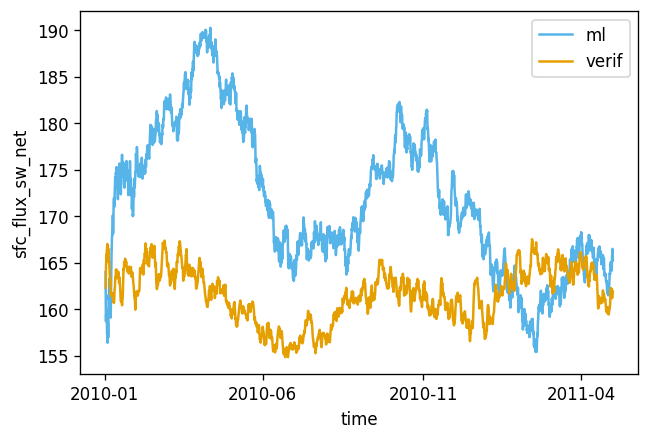

In [27]:
no_novelty_run.sfc_flux_sw_net.mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.sfc_flux_sw_net.mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

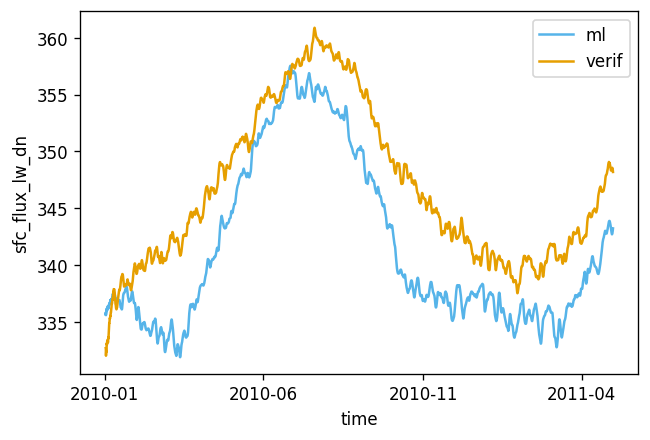

In [28]:
no_novelty_run.sfc_flux_lw_dn.mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.sfc_flux_lw_dn.mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

In [29]:
total_sfc_down_ml = no_novelty_run.sfc_flux_sw_net + no_novelty_run.sfc_flux_lw_dn
total_sfc_down_verif = verif.sfc_flux_sw_net + verif.sfc_flux_lw_dn

In [41]:
is_land = run.isel(time=0).landfrac.load() > 0

In [46]:
run["is_land"] = is_land.astype(float)

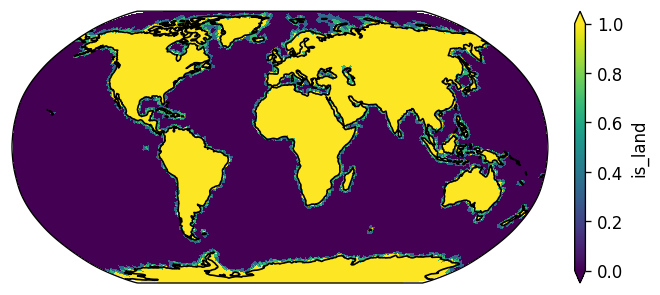

In [47]:
plot_single(run, "is_land")

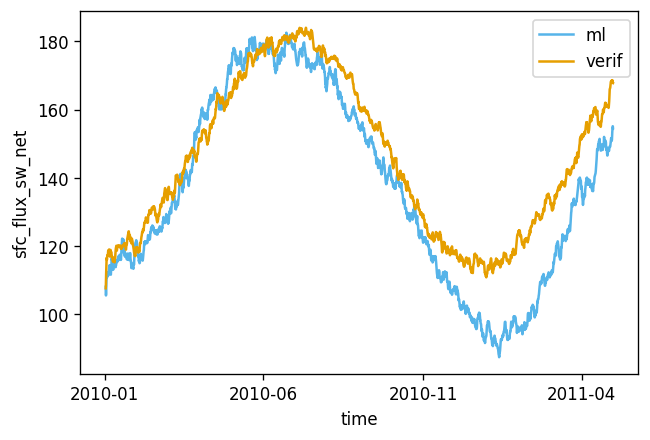

In [51]:
no_novelty_run.where(is_land).sfc_flux_sw_net.mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.where(is_land).sfc_flux_sw_net.mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

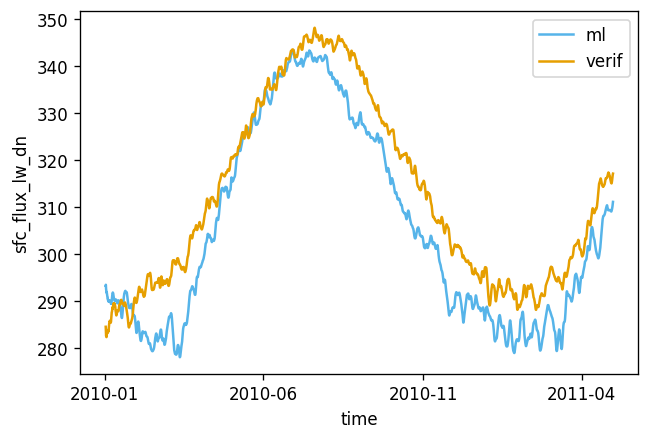

In [52]:
no_novelty_run.sfc_flux_lw_dn.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.sfc_flux_lw_dn.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

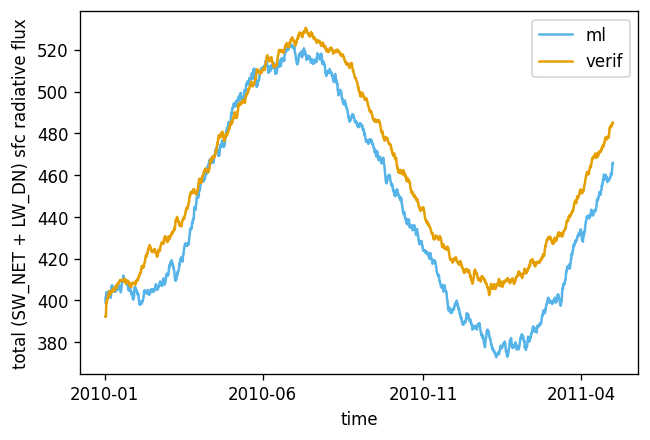

In [48]:
total_sfc_down_ml.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
total_sfc_down_verif.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.ylabel("total (SW_NET + LW_DN) sfc radiative flux")
plt.legend()
plt.show()

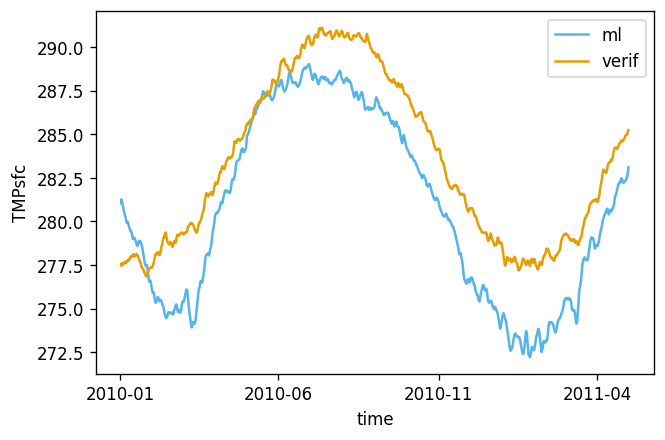

In [50]:
no_novelty_run.surf_radiative_T.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.TMPsfc.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

In [35]:
verif_phys_total_rad = verif.DLWRFsfc + (verif.DSWRFsfc - verif.USWRFsfc)

In [33]:
ml_phys_total_rad = no_novelty_run.LW_flux_dn_at_model_bot + (no_novelty_run.SW_flux_dn_at_model_bot - no_novelty_run.SW_flux_up_at_model_bot)

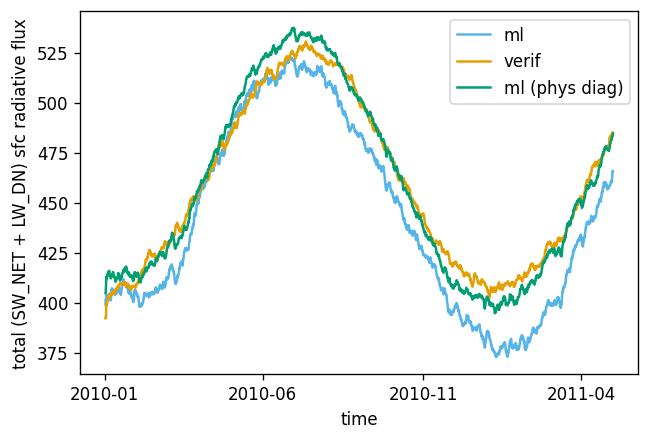

In [49]:
total_sfc_down_ml.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
total_sfc_down_verif.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
ml_phys_total_rad.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml (phys diag)")
plt.ylabel("total (SW_NET + LW_DN) sfc radiative flux")
plt.legend()
plt.show()

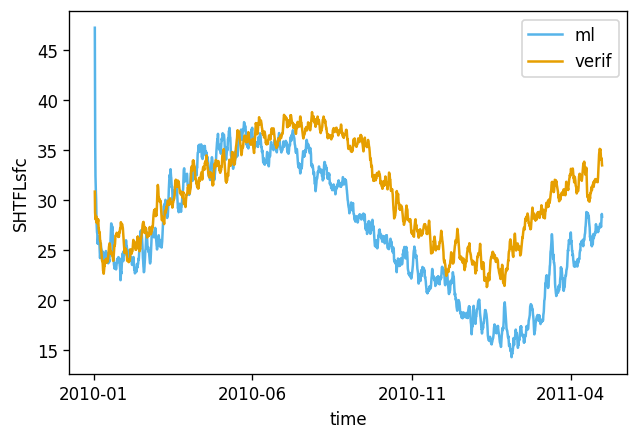

In [53]:
no_novelty_run.surf_sens_flux.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.SHTFLsfc.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

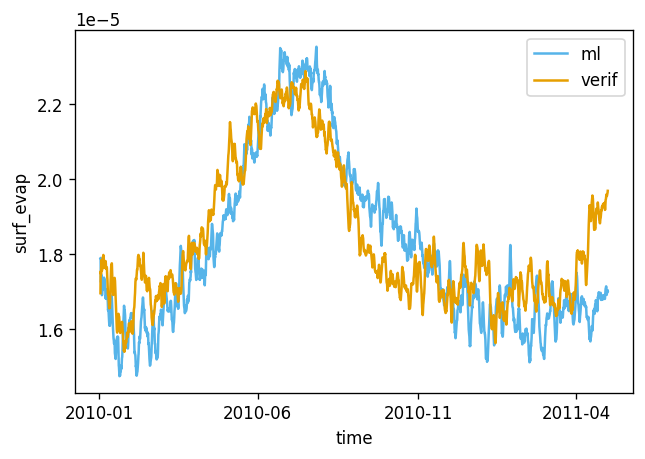

In [54]:
no_novelty_run.surf_evap.where(is_land).mean(dim="ncol").rolling(time=8).mean().plot(label="ml")
verif.surf_evap.where(is_land).mean(dim="ncol").sel(time=slice(no_novelty_run.time[-1])).rolling(time=8).mean().plot(label="verif")
plt.legend()
plt.show()

In [68]:
bias_vars = [
    "sfc_flux_lw_dn",
    "sfc_flux_sw_net",
    "surf_radiative_T",
    "VapWaterPath"
]
v2_rename = {
    "surf_radiative_T": "TMPsfc",
    "VapWaterPath": "water_vapor_path",
}

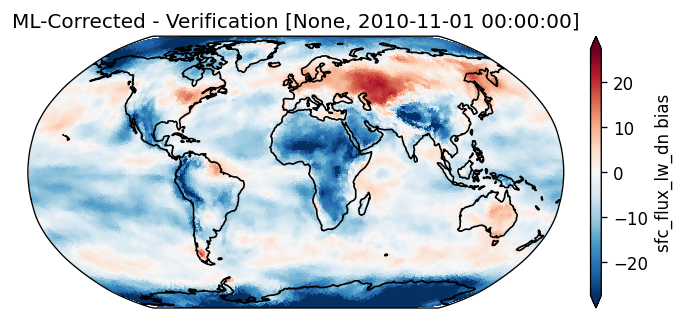

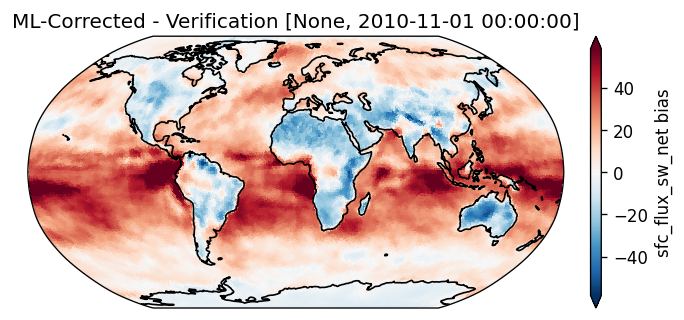

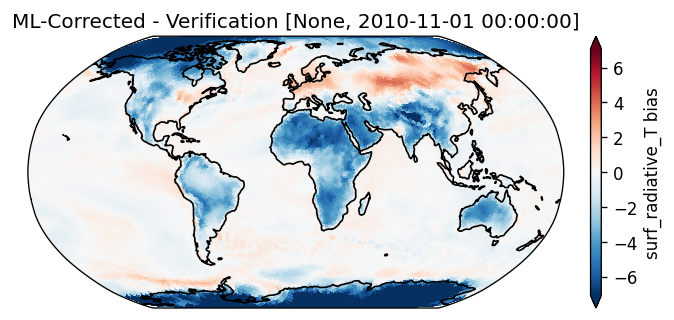

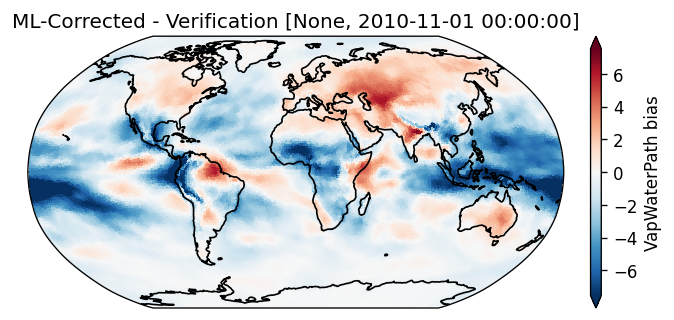

In [69]:
for v in bias_vars:
    v2 = v2_rename.get(v, v)
    start_time = None
    stop_time = cftime.DatetimeNoLeap(2010, 11, 1)
    bias = (no_novelty_run[v] - verif[v2]).sel(time=slice(start_time, stop_time)).mean(dim="time").compute()
    key = f"{v} bias"
    for_plot = xr.Dataset({
        key: bias,
        "lat": verif.lat.isel(time=0).load(),
        "lon": verif.lon.isel(time=0).load(),
    })
    plot_single(for_plot, key)
    plt.title(f"ML-Corrected - Verification [{start_time}, {stop_time}]")
    

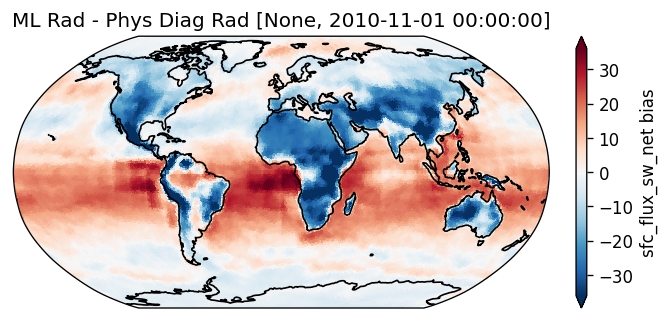

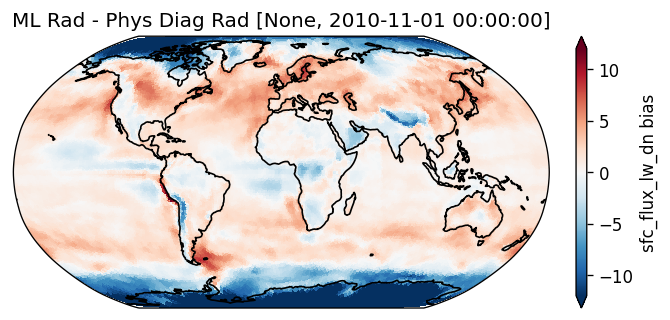

In [70]:
no_novelty_run["SW_flux_net_at_model_bot"] = (no_novelty_run.SW_flux_dn_at_model_bot - no_novelty_run.SW_flux_up_at_model_bot)
v2_diag = {
    "sfc_flux_sw_net": "SW_flux_net_at_model_bot",
    "sfc_flux_lw_dn": "LW_flux_dn_at_model_bot",
}
for v, v2 in v2_diag.items():
    start_time = None
    stop_time = cftime.DatetimeNoLeap(2010, 11, 1)
    bias = (no_novelty_run[v] - no_novelty_run[v2]).sel(time=slice(start_time, stop_time)).mean(dim="time").compute()
    key = f"{v} bias"
    for_plot = xr.Dataset({
        key: bias,
        "lat": verif.lat.isel(time=0).load(),
        "lon": verif.lon.isel(time=0).load(),
    })
    plot_single(for_plot, key)
    plt.title(f"ML Rad - Phys Diag Rad [{start_time}, {stop_time}]")

In [82]:
no_novelty_run["SW_flux_net_at_model_bot"] = (no_novelty_run.SW_flux_dn_at_model_bot - no_novelty_run.SW_flux_up_at_model_bot)
v2_diag = {
    "sfc_flux_sw_net": "SW_flux_net_at_model_bot",
    "sfc_flux_lw_dn": "LW_flux_dn_at_model_bot",
}

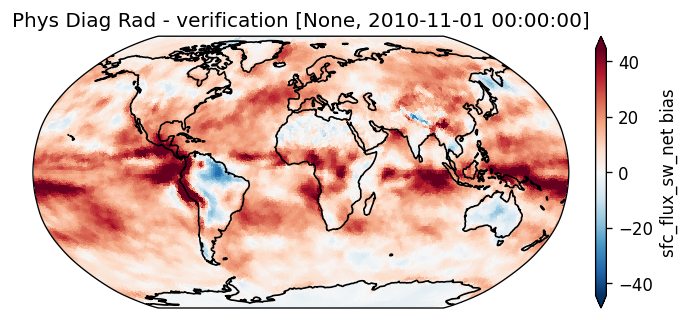

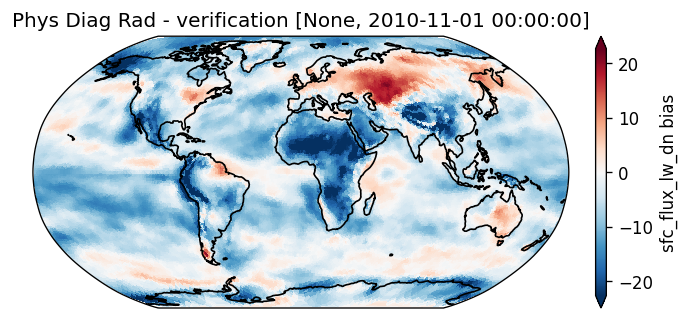

In [71]:
for v, v2 in v2_diag.items():
    start_time = None
    stop_time = cftime.DatetimeNoLeap(2010, 11, 1)
    bias = (no_novelty_run[v2] - verif[v]).sel(time=slice(start_time, stop_time)).mean(dim="time").compute()
    key = f"{v} bias"
    for_plot = xr.Dataset({
        key: bias,
        "lat": verif.lat.isel(time=0).load(),
        "lon": verif.lon.isel(time=0).load(),
    })
    plot_single(for_plot, key)
    plt.title(f"Phys Diag Rad - verification [{start_time}, {stop_time}]")

In [83]:
verif["tot_sfc_flux_lw_sw_net"] = verif.sfc_flux_lw_dn + verif.sfc_flux_sw_net
no_novelty_run["tot_sfc_flux_lw_sw_net"] = no_novelty_run.sfc_flux_lw_dn + no_novelty_run.sfc_flux_sw_net
no_novelty_run["tot_sfc_flux_diag_lw_sw_net"] = no_novelty_run.LW_flux_dn_at_model_bot + no_novelty_run.SW_flux_net_at_model_bot

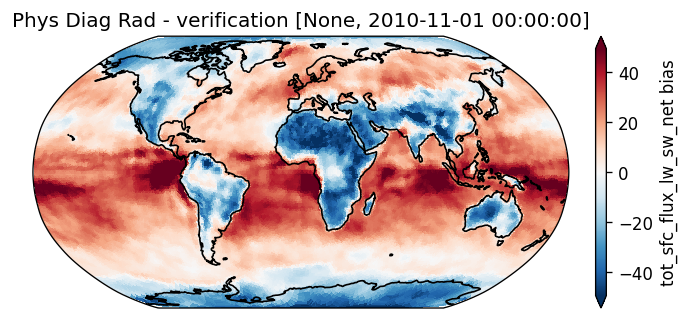

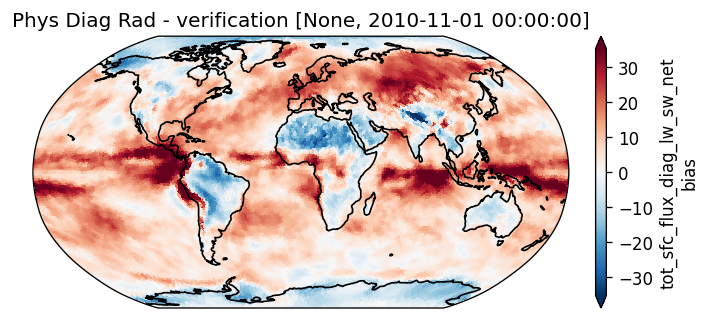

In [84]:
for v in ["tot_sfc_flux_lw_sw_net", "tot_sfc_flux_diag_lw_sw_net"]:
    start_time = None
    stop_time = cftime.DatetimeNoLeap(2010, 11, 1)
    bias = (no_novelty_run[v] - verif["tot_sfc_flux_lw_sw_net"]).sel(time=slice(start_time, stop_time)).mean(dim="time").compute()
    key = f"{v} bias"
    for_plot = xr.Dataset({
        key: bias,
        "lat": verif.lat.isel(time=0).load(),
        "lon": verif.lon.isel(time=0).load(),
    })
    plot_single(for_plot, key)
    plt.title(f"Phys Diag Rad - verification [{start_time}, {stop_time}]")